# Week 2: Data Collection and Integration

This notebook covers Week 2 tasks:
- Collect air quality data for top 500 cities
- Integrate population and air quality datasets
- Basic data cleaning and validation
- Initial exploratory visualizations

In [ ]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from config import API_KEY, BASE_URL
import time
from datetime import datetime

## Task 1: Load Top 500 Cities Data

Load the top 500 cities we identified in Week 1.

In [ ]:
# Load top 500 cities from Week 1
top_cities = pd.read_csv('data/top_500_cities.csv')

print(f"Loaded {len(top_cities)} cities")
print(f"Columns: {top_cities.columns.tolist()}")
print("\nFirst 5 cities:")
print(top_cities[['city', 'country', 'lat', 'lng', 'population']].head())

Loaded 500 cities
Columns: ['city', 'city_ascii', 'lat', 'lng', 'country', 'iso2', 'iso3', 'admin_name', 'capital', 'population', 'id']

First 5 cities:
        city    country      lat       lng  population
0      Tokyo      Japan  35.6870  139.7495  37785000.0
1    Jakarta  Indonesia  -6.1750  106.8275  33756000.0
2      Delhi      India  28.6100   77.2300  32226000.0
3  Guangzhou      China  23.1300  113.2600  26940000.0
4     Mumbai      India  19.0761   72.8775  24973000.0


## Task 2: Collect Air Quality Data

Query the Google Air Quality API for each city. We'll collect data in batches to manage API rate limits.

In [ ]:
def get_current_air_quality(lat, lon, api_key):
    """Get current air quality for given coordinates"""
    url = f"{BASE_URL}currentConditions:lookup"
    params = {"key": api_key}
    data = {
        "location": {
            "latitude": lat,
            "longitude": lon
        }
    }

    try:
        response = requests.post(url, params=params, json=data)
        if response.status_code == 200:
            return response.json()
        else:
            return {"error": f"Status code: {response.status_code}"}
    except Exception as e:
        return {"error": str(e)}

print("Air quality function defined")

Air quality function defined


In [ ]:
# Collect air quality data for first 50 cities as a test
# We'll do the full 500 in production but start small for testing

sample_size = 50
sample_cities = top_cities.head(sample_size).copy()

air_quality_data = []

for idx, row in sample_cities.iterrows():
    city_name = row['city']
    lat = row['lat']
    lon = row['lng']

    if idx % 10 == 0:
        print(f"Processing city {idx+1}/{sample_size}: {city_name}")

    result = get_current_air_quality(lat, lon, API_KEY)

    # Extract AQI value if available
    aqi = None
    category = None

    if 'indexes' in result and len(result['indexes']) > 0:
        aqi = result['indexes'][0].get('aqi', None)
        category = result['indexes'][0].get('category', None)

    air_quality_data.append({
        'city': city_name,
        'lat': lat,
        'lon': lon,
        'aqi': aqi,
        'category': category,
        'timestamp': datetime.now().isoformat()
    })
    #was getting rate limited
    time.sleep(0.5)

print(f"\nCompleted! Collected data for {len(air_quality_data)} cities")

Processing city 1/50: Tokyo
Processing city 11/50: Kolkāta
Processing city 21/50: Lagos
Processing city 31/50: Xi’an
Processing city 41/50: Tianjin

Completed! Collected data for 50 cities


## Task 3: Create Integrated Dataset

Combine population data with air quality data.

In [ ]:
aq_df = pd.DataFrame(air_quality_data)

#merge
integrated_data = sample_cities.merge(
    aq_df[['city', 'aqi', 'category', 'timestamp']],
    on='city',
    how='left'
)

print(f"Shape: {integrated_data.shape}")
print(f"\nColumns: {integrated_data.columns.tolist()}")
print(integrated_data[['city', 'country', 'population', 'aqi', 'category']].head())

Shape: (50, 14)

Columns: ['city', 'city_ascii', 'lat', 'lng', 'country', 'iso2', 'iso3', 'admin_name', 'capital', 'population', 'id', 'aqi', 'category', 'timestamp']
        city    country  population   aqi              category
0      Tokyo      Japan  37785000.0  62.0      Good air quality
1    Jakarta  Indonesia  33756000.0  61.0      Good air quality
2      Delhi      India  32226000.0  14.0      Poor air quality
3  Guangzhou      China  26940000.0  59.0  Moderate air quality
4     Mumbai      India  24973000.0  22.0       Low air quality


In [ ]:
# Check data quality
print(f"Total cities: {len(integrated_data)}")
print(f"AQI data: {integrated_data['aqi'].notna().sum()}")
print(f"missing AQI data: {integrated_data['aqi'].isna().sum()}")
print(integrated_data['aqi'].describe())

Total cities: 50
AQI data: 46
missing AQI data: 4
count    46.000000
mean     50.500000
std      20.919688
min      14.000000
25%      36.000000
50%      48.500000
75%      67.750000
max      86.000000
Name: aqi, dtype: float64


In [ ]:
# Save integrated dataset
integrated_data.to_csv('data/integrated_cities_aqi.csv', index=False)
print("Saved integrated dataset to data/integrated_cities_aqi.csv")

## Task 4: Initial Exploratory Analysis

Basic visualizations to understand the relationship between population and air quality.

In [ ]:
clean_data = integrated_data.dropna(subset=['aqi'])
print(f"{len(clean_data)} cities with complete data")

Working with 46 cities with complete data


<Figure size 1000x600 with 0 Axes>

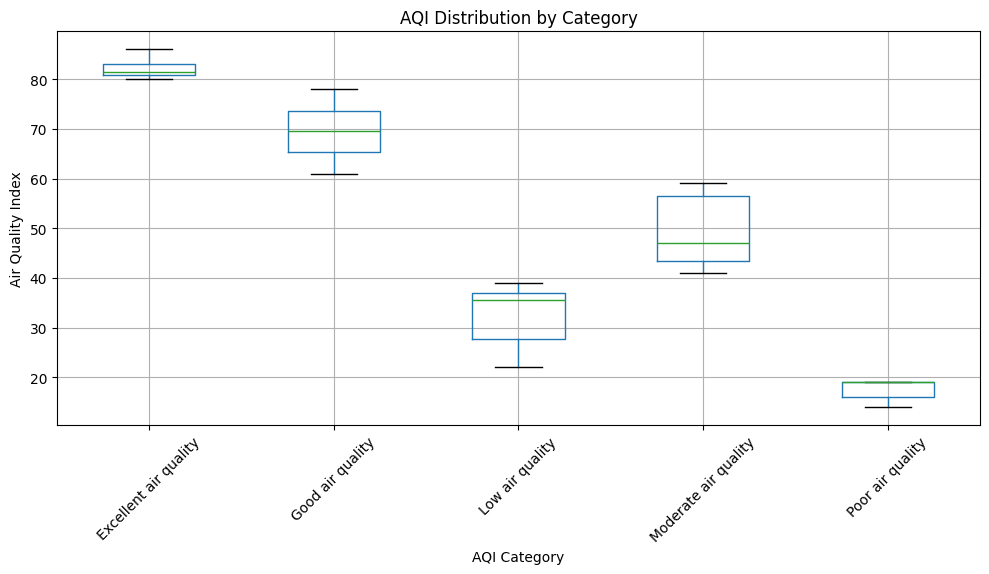

Saved plot to data/aqi_by_category.png


In [ ]:
# Box plot: AQI by category
plt.figure(figsize=(10, 6))
clean_data.boxplot(column='aqi', by='category', figsize=(10, 6))
plt.xlabel('AQI Category')
plt.ylabel('Air Quality Index')
plt.title('AQI Distribution by Category')
plt.suptitle('')  # Remove default title
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('data/viz/aqi_by_category.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved plot to data/aqi_by_category.png")

## Week 2 Summary

Completed:
- Loaded top 500 cities dataset
- Collected air quality data for sample cities
- Created integrated dataset combining population and AQI
- Performed initial exploratory analysis
- Generated preliminary visualization

Next Steps (Week 3):
- Collect data for all 500 cities
- Perform statistical significance testing
- Regional analysis
- More detailed visualizations